## Measurement plotter
A notebook to plot growth monitoring of mouse PDX models.
See ./examples/ for data format.<br>
This was used primarily for data QC for our publication:<br>
https://www.biorxiv.org/content/10.1101/2023.01.06.521078v1

In [1]:
import pandas as pd
import numpy as np
#%matplotlib inline
%matplotlib Agg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
import ipywidgets as widgets
from scipy.optimize import curve_fit
from pathlib import Path

In [2]:
out_dir = Path("./examples/output")

tracker_excel = Path("./examples/ExampleTrackerData.xlsx")
tracker_sheet = "PDX_Tracker"

cohort_excel = Path("./examples/ExampleTrackerData.xlsx")
patient_sheet = "Patient_Data"
region_sheet = "Region_Data"

measurements_excel = Path("./examples/ExampleTrackerData.xlsx")
measurements_sheet = "Measurements"

In [3]:
def load_tracker(remove_exclude = False, outcome = None):
    #global tracker_df
    tracker_df = pd.read_excel(tracker_excel,sheet_name=tracker_sheet)#, index_col=0)
    tracker_df["RegionID"] = tracker_df["DonorID"].astype(str) + "_" + tracker_df["Tumour"].astype(str) + "-" + tracker_df["Region"].astype(str)
    
    tracker_df.loc[pd.isnull(tracker_df["Lineage"]),"Lineage"] = "A0"
    tracker_df["SampleID"] = tracker_df["RegionID"].astype(str) + "-P" + tracker_df["Passage"].astype(str) + "-" + tracker_df["Lineage"].astype(str)
    
    use_cols = ["SiteID","RegionID","SampleID","DonorID","Tumour","Region","Lineage","Passage","Injection",\
                "FvsF","Culled","DaysCalc","LastDetected","Parent", "IsParent","WES_ID","WES_lineage","ExcludeMouse",\
                "CullReason","IHC outcome inferred"]
    tracker_df = tracker_df[use_cols].set_index("SiteID")

    #remove any parent-less P>0 as incomplete
    tracker_df = tracker_df.loc[~((tracker_df["Passage"]>0) & (tracker_df["Parent"].isnull()))]

    if remove_exclude:
        tracker_df = tracker_df[~(tracker_df["ExcludeMouse"]==1.0)]

    if outcome is not None:
        tracker_df = tracker_df[tracker_df["IHC outcome inferred"]==outcome]

    # sort by passage so iterrows below calculates time linearly
    tracker_df = tracker_df.sort_values("Passage")
    
    tracker_df.loc[tracker_df["Passage"]==0,"StartDays"] = 0
    tracker_df.loc[tracker_df["Passage"]==0,"EndDays"] = tracker_df.loc[tracker_df["Passage"]==0,"DaysCalc"]

    for ix, row in tracker_df.dropna(subset=["Parent"]).iterrows():
        tracker_df.loc[ix,"StartDays"] = tracker_df.loc[tracker_df.loc[ix,"Parent"],"EndDays"]
        tracker_df.loc[ix,"EndDays"] = tracker_df.loc[ix,"StartDays"] + tracker_df.loc[ix,"DaysCalc"] 
    return tracker_df

In [4]:
def load_meta():
    patient_data = pd.read_excel(cohort_excel,sheet_name=patient_sheet)
    patient_data = patient_data.set_index("DonorID")
    #display(patient_data)

    pdx_data = pd.read_excel(cohort_excel,sheet_name=region_sheet)
    pdx_data["RegionID"] = pdx_data["DonorID"] + "_" + pdx_data["Region"]
    use_cols = ["RegionID","IHC","CanonicalLineage"]
    pdx_data = pdx_data[use_cols].set_index("RegionID")
    #display(pdx_data)
    return patient_data, pdx_data

In [5]:
def load_measurements():
    return pd.read_excel(measurements_excel,sheet_name=measurements_sheet).set_index("RecordId")

In [6]:
tracker_df = load_tracker(True,"Good")
patient_df, pdx_df = load_meta()
measurements_df = load_measurements()

print(f"Tracker: {len(tracker_df)}")
print(f"Patient: {len(patient_df)}")
print(f"PDX: {len(pdx_df)}")
print(f"Measurements: {len(measurements_df)}")

Tracker: 23
Patient: 1
PDX: 8
Measurements: 433


In [7]:
def get_plot_df(target_site):
    #target_site = target~_select.value
    target_df = measurements_df[measurements_df.SiteId == target_site].copy()

    regionInfo = tracker_df.loc[target_site].copy()
    regionInfo["TotalDays"] = regionInfo["Culled"] - regionInfo["Injection"]
    regionInfo["TotalDays"] = regionInfo["TotalDays"].days

    target_df["DateDelta"] = target_df["Date"] - regionInfo["Injection"]
    target_df["DateDelta"] = target_df["DateDelta"].dt.days
    #target_df["maxDim"] = target_df[["Dim1","Dim2"]].apply(max, axis=1)

    plot_df = target_df[["DateDelta","TumourPresent","SA","Volume"]].reset_index(drop=True).copy()
    plot_df.sort_values("DateDelta",inplace=True)
    #Add cull date without measurements to allow filling of detection boxes
    detected_at_cull = plot_df.TumourPresent.iat[-1] if len(plot_df) > 0 else False
    plot_df = pd.concat([plot_df,pd.DataFrame([{"DateDelta":regionInfo["TotalDays"],"TumourPresent": detected_at_cull, "SA":np.nan, "Volume":np.nan}])],ignore_index=True)
    
    return plot_df

In [8]:
def lin_form(x, m, c):
    return m*x+c

def quad_form(x, a, b, c):
    return a*x**2+b*x+c

def exp_form(x, a, b, c):
    return a**x*b+c

In [9]:
plt.rcParams.update({'font.size': 6})
def plot_sites_cont(site_list, plot_param="SA", x_max = None, y_max = None):
    """[siteId, label, plotDf, colour]"""
    
    fig_width = 4
    fig_height = 1.2
    fig1, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(fig_width, fig_height), 
                                       dpi=240, gridspec_kw = {'height_ratios':[2,1],'hspace':0.1})#, sharex=True)

    #ax2.set_ylim(-4,0)
    
    bar_y = -1
    ticks_y = []
    days_offset = 0
    counter = 1
    for s in site_list:
        """[siteId, label, plotDf, colour]"""
        p_df = s[2].copy()
        p_df["DateDelta"] += days_offset
        
        xdata = p_df[pd.notnull(p_df[plot_param])].DateDelta
        ydata = p_df[pd.notnull(p_df[plot_param])][plot_param]

        #-----------
        # scatter plot the measurements
        ax1.scatter(
            xdata,
            ydata,
            color = s[3],
            s=1
        )
        
        #-----------
        # Fit a curve
        p_df.loc[:,"PresentChange"] = (p_df.TumourPresent != p_df.TumourPresent.shift())
        lastdetected = p_df[p_df["PresentChange"] == True].DateDelta.max()

        fitxdata = p_df[pd.notnull(p_df[plot_param]) & (p_df.DateDelta>=lastdetected)].DateDelta
        fitydata = p_df[pd.notnull(p_df[plot_param]) & (p_df.DateDelta>=lastdetected)][plot_param]

        # if enough data plot a quadratic form else plot linear (ie two data points)
        if len(fitxdata) > 2:
            popt, pcov = curve_fit(quad_form, fitxdata, fitydata)
            ax1.plot(fitxdata, quad_form(fitxdata, *popt), s[3], linewidth=1)#, label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        else:
            ax1.plot(fitxdata, fitydata, s[3], linewidth=1)
        
        #-----------
        
        bars = []
        for i in p_df.index.values[:-1]:
            if p_df.loc[i,"TumourPresent"]:
                bar_start = p_df.loc[i,"DateDelta"]
                bar_len = p_df.loc[i+1,"DateDelta"] - bar_start
                bars.append((bar_start, bar_len))

        ax2.broken_barh(bars, (bar_y+0.1,0.8), facecolors=s[3])
        ax2.hlines(bar_y+0.5, days_offset,p_df["DateDelta"].max(),linewidth=0.7,color = "grey")
        #if counter < len(site_list):
        #    ax2.text(days_offset+2,bar_y+0.1, "\u21B3", va = "top", ha = "center")
        counter += 1
        
        days_offset = p_df["DateDelta"].max()
        ticks_y.append((bar_y+0.5,s[1]))
        bar_y -= 1


    ax1.set_xticks([])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_ylim(bottom=0)
    if plot_param == "SA":
        ax1.set_ylabel("Surface Area")
    elif plot_param == "maxDim":
        ax1.set_ylabel("Max Dim")
    elif plot_param == "Volume":
        ax1.set_ylabel("Tumour Volume \n/mm\u00b3")
    else:
        ax1.set_ylabel(plot_param)
    ax1.set_xlim(0,days_offset)
    if x_max is not None:
        ax1.set_xlim(0,x_max)
    if y_max is not None:
        ax1.set_ylim(0,y_max)

    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    #ax2.set_yticks(ticks_y)
    ax2.set_yticks([y[0] for y in ticks_y])
    ax2.set_yticklabels([y[1] for y in ticks_y])
    ax2.set_xlabel("Days since P0 injection")
    ax2.set_xlim(0,days_offset)
    if x_max is not None:
        ax2.set_xlim(0,x_max)

    return fig1

In [10]:
def get_ancestors(SiteID):
    ancestors = {}
    ancestors[tracker_df.loc[SiteID,"Passage"]] = SiteID
    next_parent = tracker_df.loc[SiteID,"Parent"]
    while pd.notnull(next_parent):
        ancestors[tracker_df.loc[next_parent,"Passage"]] = next_parent
        next_parent = tracker_df.loc[next_parent,"Parent"]
    return ancestors

In [11]:
def get_plot_info(SiteID):
    colours = {
        0.0: "tab:blue",
        0.5: "tab:blue",
        1.0: "tab:orange",
        1.5: "tab:orange",
        2.0: "tab:green",
        2.5: "tab:green",
        3.0: "tab:purple",
        3.5: "tab:purple",
    }
    
    #["LAMIS-166222:2_R","P1",get_plot_df("LAMIS-166222:2_R"),],
    plot_list = []
    ancestors = get_ancestors(SiteID)
    for p in sorted(ancestors.keys()):
        plot_list.append([ancestors[p],f"P{int(p)}",get_plot_df(ancestors[p]),colours.get(p,"k")])
    return plot_list
    

In [12]:
target_select = widgets.Dropdown(
    options=sorted([tuple(r) for r in tracker_df.reset_index()[["SampleID","SiteID"]].to_numpy()]))
display(target_select)

Dropdown(options=(('CRUK0949_T1-R1-P0-A0', 'L-147838:1_R'), ('CRUK0949_T1-R1-P1-A0', 'L-152606:3_R'), ('CRUK09…

C:\Users\dave2\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


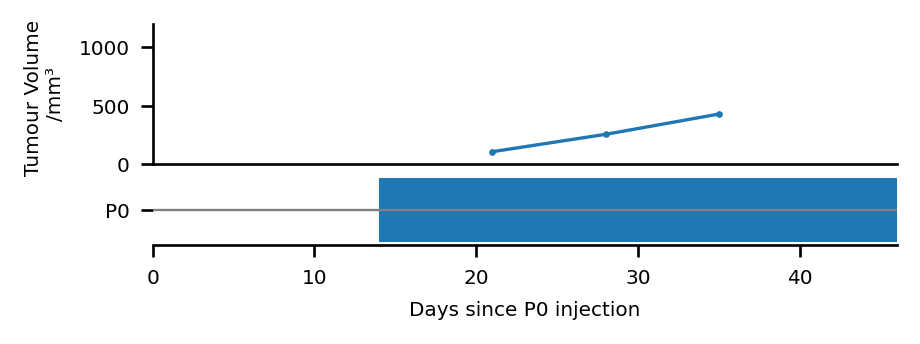

In [13]:
plot_sites_cont(get_plot_info(target_select.value), "Volume", y_max = 1200)

CRUK0949_PDX_T1-R1-P3-A0


C:\Users\dave2\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


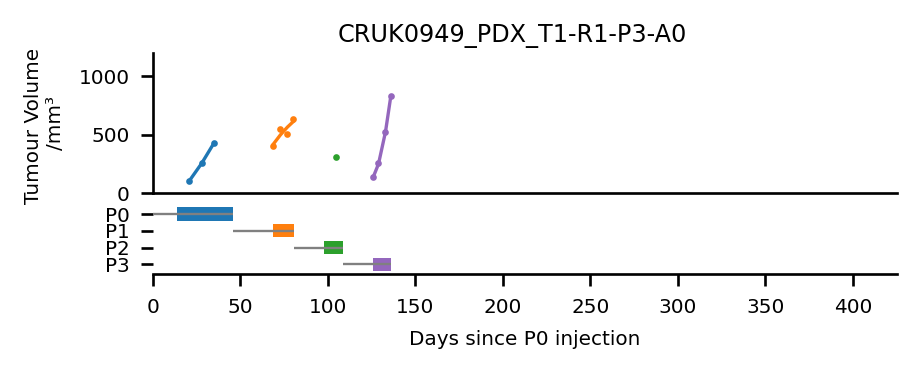

CRUK0949_PDX_T1-R3-P3-A0


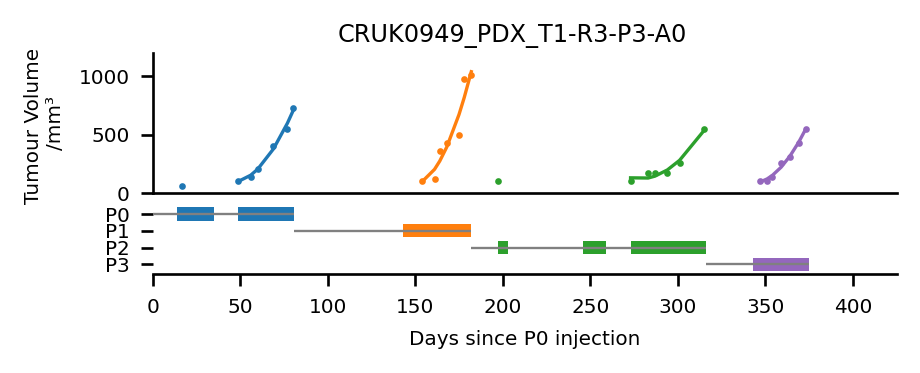

CRUK0949_PDX_T1-R4-P3-A0


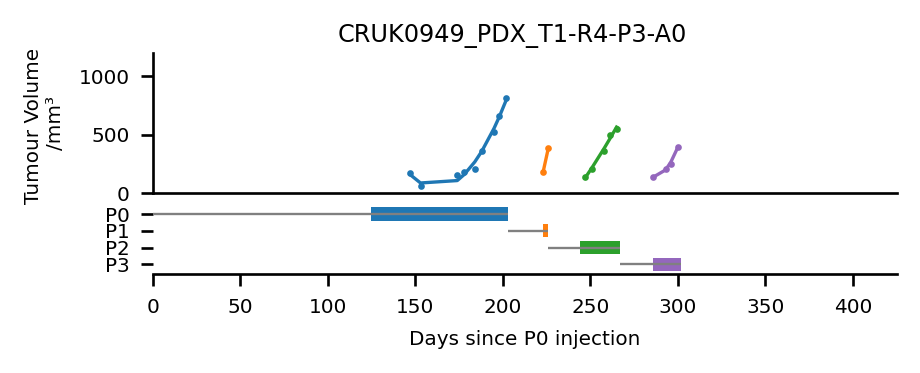

CRUK0949_PDX_T1-R5-P3-A0


C:\Users\dave2\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


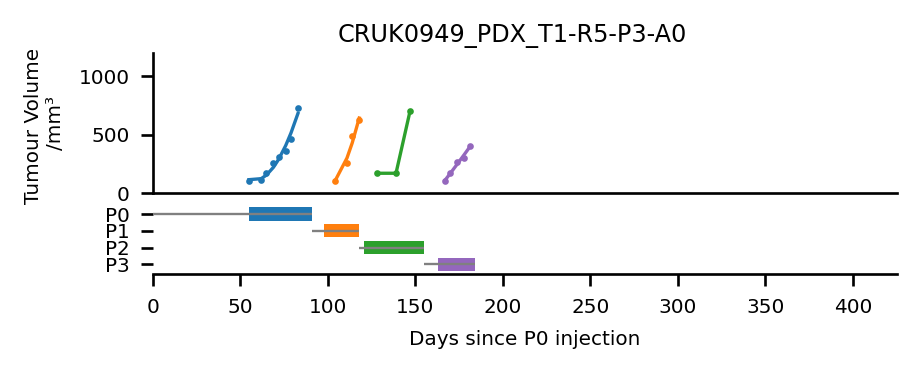

Done. Made: 4


In [14]:
# get df containing only those used for WES at P3 to plot the lineages of interest
temp_df = tracker_df[pd.notnull(tracker_df["WES_ID"])].reset_index()[["WES_ID","SiteID"]]
temp_df = temp_df[temp_df["WES_ID"].str.contains("P3")].sort_values(by="WES_ID")

made = 0
for _,row in temp_df.iterrows():
    print(row["WES_ID"])
    fig = plot_sites_cont(get_plot_info(row["SiteID"]), "Volume", x_max=425, y_max = 1200)
    fig.suptitle(row["WES_ID"])
    display(fig)
    fig.savefig(Path(out_dir,f"Growth - {row['WES_ID']}.png"), bbox_inches='tight')
    plt.close(fig)
    made += 1
print(f"Done. Made: {made}")
    